In [1]:
import csv
import numpy as np
import math as mp
import cmath as cm
from scipy.optimize import fsolve, root, fmin

import matplotlib as mpl
import matplotlib.pyplot as plt

def bestSaveFig(name):
    plt.savefig(name, bbox_inches = 'tight', pad_inches = 0.1, dpi = 500)
    
def dataGet(stFN):
    boi = csv.reader(open(stFN, "r"), delimiter=',')
    
    dep = []
    real = []
    imag = []
    mag = []
    for row in boi:
        dep.append(float(row[0]))
        real.append(float(row[1]))
        imag.append(float(row[2]))
        mag.append(float(row[3]))
        
    return([dep, real, imag, mag])

def sweepConsol_nstFSv02(sweepSet):
    freq = []
    realSig = []
    imagSig = []
    
    for sweep in sweepSet:
        fn_freq1 = "FrequencySweep_"+str(sweep)+".csv"

        data_freq1 = dataGet(fn_freq1)
        freq = np.concatenate((freq, data_freq1[0]))
        realSig = np.concatenate((realSig, data_freq1[1]))
        imagSig = np.concatenate((imagSig, data_freq1[2]))
    
    return(freq, realSig, imagSig)

def sweepSig_nstFSv02(sweepSet):
    freq, realSig, imagSig = sweepConsol_nstFSv02(sweepSet)
    magSig = np.sqrt(np.add(np.square(realSig), np.square(imagSig)))
    
    return(freq, realSig, imagSig, magSig)
    

In [38]:
def admittances(f, R, C, lvec):
    w = 2 * mp.pi * f
    Zc = cm.sqrt(R / (1j * w * C))
    gamm = cm.sqrt(R * (1j * w * C))
    zeta = 0

    Y = (1 / Zc) * (cm.sinh(gamm * lvec[0]) * cm.sinh(gamm * lvec[2])) / cm.sinh(gamm * (sum(lvec)))
    
    return(Y)

def admittancevec(fvec, R, C, lvec):
    Yout = []
    for it in range(len(fvec)):
        Yout.append(admittances(fvec[it], R, C, lvec))
    return(np.array(Yout))

def kfSolverTot(freqs, dep, lengths):
    Rg = 2.3e10
    Cg = 2.3e-8

    freqs = np.array(freqs)
    dep = np.array(dep)
    
    params = [Rg, Cg]
    
    out = fmin(residual, params, args = (freqs, dep, lengths), disp = 0)
    return(out)

def residual(params, x, data, lvec):
    R = params[0]
    C = params[1]

    model = admittancevec(x, R, C, lvec)

    return(abs(data - model).sum())

def getvecreal(imvec):
    res = []
    for comp in imvec:
        res.append(comp.real)
    
    return(np.array(res))

def getvecimag(imvec):
    res = []
    for comp in imvec:
        res.append(comp.imag)
    
    return(np.array(res))

In [39]:
#----------

sg_1 = [6098, 6099, 6100, 6101, 6102]
sg_2 = [6103, 6104, 6105, 6106, 6107]
sg_3 = [6108, 6109, 6110, 6111, 6112]
sg_4 = [6128, 6129, 6130, 6131, 6132]

freq_1, realSig_1, imagSig_1, magSig_1 = sweepSig_nstFSv02(sg_1)
freq_2, realSig_2, imagSig_2, magSig_2 = sweepSig_nstFSv02(sg_2) #not used
freq_3, realSig_3, imagSig_3, magSig_3 = sweepSig_nstFSv02(sg_3)

#----------

freq = freq_1

realSignal = np.subtract(realSig_3 * (1e0/20e-3), realSig_1 * (1e0/4e-3))
imagSignal = np.subtract(imagSig_3 * (1e0/20e-3), imagSig_1 * (1e0/4e-3))
magnSignal = np.sqrt(np.add(np.square(realSignal),np.square(imagSignal)))

magnSignal_lg = np.sqrt(np.add(np.square(realSignal),np.square(imagSignal)))

#----------

In [40]:
l1 = 4e-4
l2 = 1e-3
l3 = 1e-3
lvec = [l1, l2, l3]

yvec = np.multiply(1, np.add(realSignal, np.multiply(1j, imagSignal)))

#print(yvec)

Rlf, Clf = (kfSolverTot(freqs=freq, dep=yvec, lengths = lvec))

Cl = (8.85e-12 * 8e-3) / (5e-9)
print(Cl)

yvecf = admittancevec(freq, Rlf, Clf, lvec)

1.4160000000000002e-05


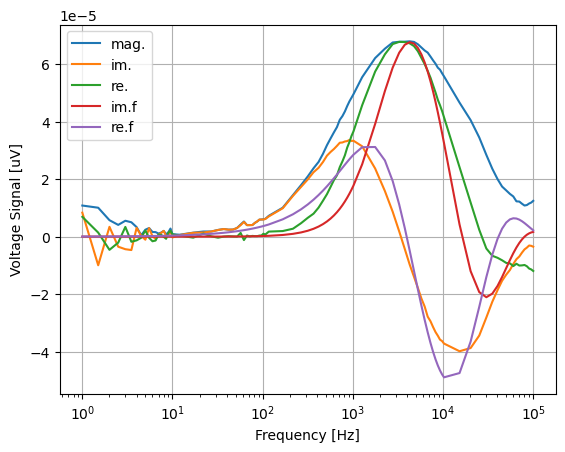

In [41]:
plt.plot(freq, magnSignal, label = "mag.")
plt.plot(freq, imagSignal, label = "im.")
plt.plot(freq, realSignal, label = "re.")

plt.plot(freq, getvecreal(yvecf), label = "im.f")
plt.plot(freq, getvecimag(yvecf), label = "re.f")

plt.xscale("log")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Voltage Signal [uV]")
plt.legend()
plt.grid()

#bestSaveFig(name="diffInput_03_2025-06-24.png")
plt.show()

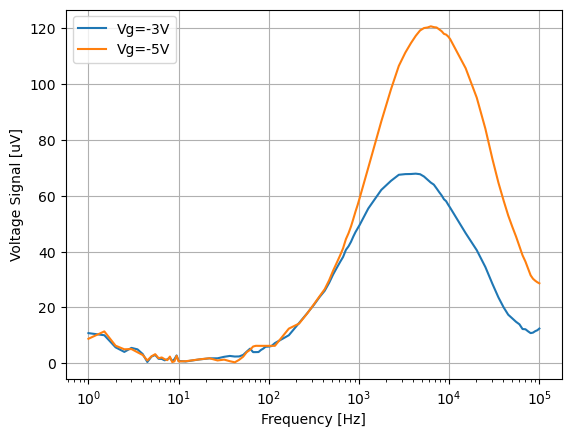

In [41]:
plt.plot(freq, magnSignal_lg, label = "Vg=-3V")
plt.plot(freq, magnSignal_hg, label = "Vg=-5V")

plt.xscale("log")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Voltage Signal [uV]")
plt.legend()
plt.grid()

#bestSaveFig(name="trapVoltageComp_2025-06-24.png")
plt.show()

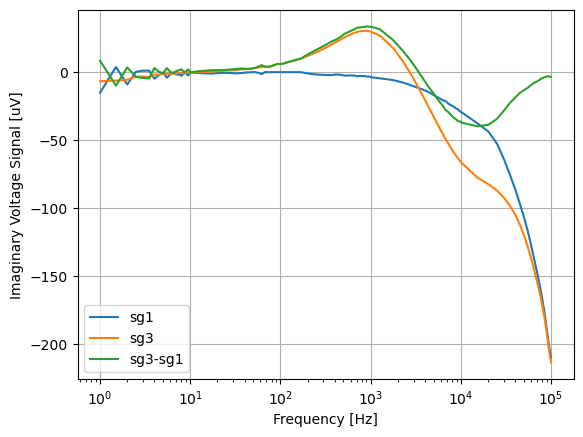

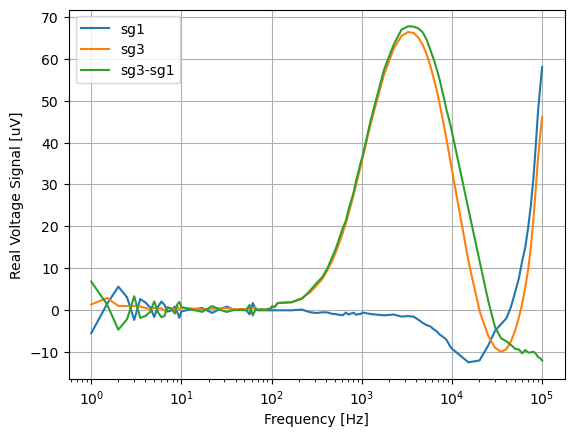

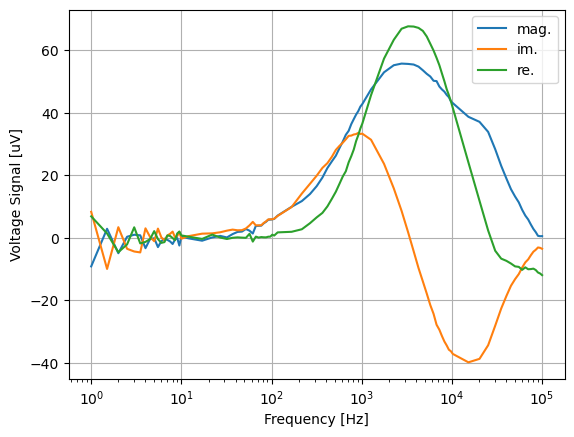

In [30]:
#----------

plt.plot(freq_1, imagSig_1 * (1e6/4e-3), label = "sg1")

#plt.plot(freq_2, imagSig_2 * (1e6/4e-3), label = "sg2")

plt.plot(freq_3, imagSig_3 * (1e6/20e-3), label = "sg3")

plt.plot(freq_1, np.subtract(imagSig_3 * (1e6/20e-3), imagSig_1 * (1e6/4e-3)), label = "sg3-sg1")

plt.xscale("log")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Imaginary Voltage Signal [uV]")
plt.legend()
plt.grid()

#bestSaveFig(name="imagDiffInput_01_2025-06-24.png")
plt.show()

#----------

#----------

plt.plot(freq_1, realSig_1 * (1e6/4e-3), label = "sg1")

#plt.plot(freq_2, realSig_2 * (1e6/4e-3), label = "sg2")

plt.plot(freq_3, realSig_3 * (1e6/20e-3), label = "sg3")

plt.plot(freq_1, np.subtract(realSig_3 * (1e6/20e-3), realSig_1 * (1e6/4e-3)), label = "sg3-sg1")

plt.xscale("log")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Real Voltage Signal [uV]")
plt.legend()
plt.grid()

#bestSaveFig(name="realDiffInput_01_2025-06-24.png")
plt.show()

#----------

#----------

plt.plot(freq_1, np.subtract(magSig_3 * (1e6/20e-3), magSig_1 * (1e6/4e-3)), label = "mag.")
plt.plot(freq_1, np.subtract(imagSig_3 * (1e6/20e-3), imagSig_1 * (1e6/4e-3)), label = "im.")
plt.plot(freq_1, np.subtract(realSig_3 * (1e6/20e-3), realSig_1 * (1e6/4e-3)), label = "re.")

plt.xscale("log")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Voltage Signal [uV]")
plt.legend()
plt.grid()

#bestSaveFig(name="diffInput_01_2025-06-24.png")
plt.show()

#----------